TODO: 


*   ~~Create Obscurity Functions~~
*   ~~Apply to dataset~~
*   ~~Create smaller copy of dataset?~~
*   ~~Train Model on applied dataset~~
*   ~~Get pre-trained segmentation model~~
*   ~~Train image recovery model~~
*   Get FID, IS and PSNR functions from tfgan
*   Create flow for function of programme



In [1]:
!pip install tensorflow_gan
!git clone https://github.com/tensorflow/models.git
%cd '/content/models/research'
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .

!python -m pip install -q .

     |████████████████████████████████| 367 kB 5.0 MB/s 
Cloning into 'models'...
remote: Enumerating objects: 72189, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 72189 (delta 1), reused 8 (delta 1), pack-reused 72179
Receiving objects: 100% (72189/72189), 578.95 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (51052/51052), done.
/content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.2 MB 8.6 MB/s 
     |████████████████████████████████| 352 kB 46.3 MB/s 
     |████████████████████████████████| 2.2 MB 35.5 MB/s 
    

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import tensorflow_gan
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz
from object_detection.utils.label_map_util import create_category_index_from_labelmap
tf.config.run_functions_eagerly(True)


from IPython.display import clear_output

import os
from time import time
from datetime import datetime
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import PIL
import imageio
from random import randint

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [ ]:
!nvidia-smi

Fri Apr 22 18:26:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#@title Variables {run:"auto"}
#@markdown ###Model variables
BATCH_SIZE =   4#@param{type:"integer"}
GEN_LR =  1e-4 #@param{}
CRITIC_LR = 1e-4 #@param
DROPOUT_RATE = 0.3 #@param
CRITIC_ITERATIONS =   5#@param{type:"integer"}
CLIP_WEIGHT = 0.01 #@param

MASK_OUTPUT_CHANNELS = 1
IMAGE_OUTPUT_CHANNELS = 3 
IMAGE_SIZE = 256


#@markdown ---
#@markdown ###Mask Dataset Paths
MASK_TRAIN_INPUT_PATH = "/content/AHP_Slice/train/ObsAnnotations" #@param{type:"string"}
MASK_TRAIN_OUTPUT_PATH = "/content/AHP_Slice/train/Annotations" #@param{type:"string"}
MASK_EVAL_INPUT_PATH = "/content/AHP_Slice/val/ObsAnnotations" #@param{type:"string"}
MASK_EVAL_OUTPUT_PATH = "/content/AHP_Slice/val/Annotations" #@param{type:"string"}
MASK_TEST_PATH = "/content/AHP_Slice/test/Annotations" #@param{type:"string"}

#@markdown ---
#@markdown ###Image Dataset Paths
IMAGE_TRAIN_INPUT_PATH = "/content/AHP_Slice/train/ObsImages" #@param{type:"string"}
IMAGE_TRAIN_OUTPUT_PATH = "/content/AHP_Slice/train/JPEGImages" #@param{type:"string"}
IMAGE_EVAL_INPUT_PATH = "/content/AHP_Slice/val/ObsImages" #@param{type:"string"}
IMAGE_EVAL_OUTPUT_PATH = "/content/AHP_Slice/val/JPEGImages" #@param{type:"string"}
IMAGE_TEST_PATH = "/content/AHP_Slice/test/JPEGImages" #@param{type:"string"}

##Colab

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
!unzip "/content/drive/MyDrive/Uni Files/KV6003/AHP_Slice.zip" -d /content/
clear_output()

#Dataset

In [9]:
def get_mtrain_ds():
    raw_train_input_ds = tf.keras.utils.image_dataset_from_directory(
        MASK_TRAIN_INPUT_PATH,
        labels=None,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False,
    )
    raw_train_input_ds = raw_train_input_ds.map(lambda x: (x/127.5))
    raw_train_input_ds = raw_train_input_ds.map(lambda x: x[:,:,:,0])

    raw_train_output_ds = tf.keras.utils.image_dataset_from_directory(
        MASK_TRAIN_OUTPUT_PATH,
        labels=None,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False
    )
    raw_train_output_ds = raw_train_output_ds.map(lambda x: (x / 225))
    raw_train_output_ds = raw_train_output_ds.map(lambda x: x[:,:,:,0])

    ds =  tf.data.Dataset.zip((raw_train_input_ds, raw_train_output_ds))
    
    return ds 

def get_mval_ds():
    raw_val_input_ds = tf.keras.utils.image_dataset_from_directory(
        MASK_EVAL_INPUT_PATH,
        labels=None,
        batch_size=1,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False,
    )
    raw_val_input_ds = raw_val_input_ds.map(lambda x: (x/225))
    raw_val_input_ds = raw_val_input_ds.map(lambda x: x[:,:,:,0])

    raw_val_output_ds = tf.keras.utils.image_dataset_from_directory(
        MASK_EVAL_OUTPUT_PATH,
        labels=None,
        batch_size=1,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False,
    )
    raw_val_output_ds = raw_val_output_ds.map(lambda x: (x/225))
    raw_val_output_ds = raw_val_output_ds.map(lambda x: x[:,:,:,0])

    ds = tf.data.Dataset.zip((raw_val_input_ds, raw_val_output_ds))
    
    return ds 

In [10]:
def get_itrain_ds():
    raw_train_input_ds = tf.keras.utils.image_dataset_from_directory(
        IMAGE_TRAIN_INPUT_PATH,
        labels=None,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False,
    )
    raw_train_input_ds = raw_train_input_ds.map(lambda x: (x/127.5)-1)

    raw_train_mask_ds = tf.keras.utils.image_dataset_from_directory(
        MASK_TRAIN_OUTPUT_PATH,
        labels=None,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False
    )
    raw_train_mask_ds = raw_train_mask_ds.map(lambda x: (x/127.5)-1)
    raw_train_mask_ds = raw_train_mask_ds.map(lambda x: x[:,:,:,0])

    raw_train_output_ds = tf.keras.utils.image_dataset_from_directory(
        IMAGE_TRAIN_OUTPUT_PATH,
        labels=None,
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False
    )
    raw_train_output_ds = raw_train_output_ds.map(lambda x: (x/127.5)-1)

    ds =  tf.data.Dataset.zip((raw_train_input_ds, raw_train_mask_ds, raw_train_output_ds))
    
    return ds 

def get_ival_ds():
    raw_val_input_ds = tf.keras.utils.image_dataset_from_directory(
        IMAGE_EVAL_INPUT_PATH,
        labels=None,
        batch_size=1,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False,
    )
    raw_val_input_ds = raw_val_input_ds.map(lambda x: (x/127.5)-1)

    raw_val_mask_ds = tf.keras.utils.image_dataset_from_directory(
        MASK_EVAL_OUTPUT_PATH,
        labels=None,
        batch_size=1,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False,
    )
    raw_val_mask_ds = raw_val_mask_ds.map(lambda x: (x/127.5)-1)
    raw_val_mask_ds = raw_val_mask_ds.map(lambda x: x[:,:,:,0])

    raw_val_output_ds = tf.keras.utils.image_dataset_from_directory(
        IMAGE_EVAL_OUTPUT_PATH,
        labels=None,
        batch_size=1,
        image_size=(IMAGE_SIZE,IMAGE_SIZE),
        shuffle=False,
    )
    raw_val_output_ds = raw_val_output_ds.map(lambda x: (x/127.5)-1)

    ds = tf.data.Dataset.zip((raw_val_input_ds, raw_val_mask_ds, raw_val_output_ds))
    
    return ds 

In [11]:
def get_mask_ds():
    train_ds =  get_mtrain_ds()
    val_ds = get_mval_ds()
    return train_ds, val_ds

In [12]:
def get_image_ds():
    train_ds = get_itrain_ds()
    val_ds = get_ival_ds()
    return train_ds, val_ds

In [13]:
m_train_ds, m_val_ds = get_mask_ds()

Found 564 files belonging to 1 classes.
Found 564 files belonging to 1 classes.
Found 3 files belonging to 1 classes.
Found 3 files belonging to 1 classes.


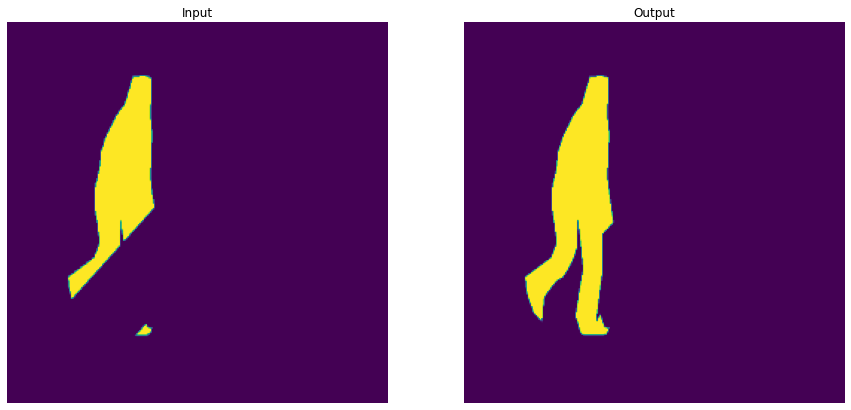

(256, 256) (256, 256)


In [14]:
for input_batch, output_batch in m_train_ds.repeat().take(1):
    for input_tens, output_tens in zip(input_batch, output_batch):
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.title("Input")
        plt.imshow(tf.squeeze(input_tens) * 255)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title("Output")
        plt.imshow(tf.squeeze(output_tens) * 255)
        plt.axis('off')
        plt.show()
        print(input_tens.shape, output_tens.shape)
        break

#Models

##Layer Functions



In [15]:
def downsample1D(filters:int, size:int, i:int, apply_batchnorm = True) -> tf.keras.Model:
    """
    1 dimension version of the downsample layer function.
    Function to assemble each downsampling 'layer' of a network. Intended to funnel into more downsampling layers until bottleneck is reached.
    
    filters (int): dimensionality of the output of the convolutional layer (and therefore what will be passed to the next layer)
    size (int): height and width of the convolutional window
    i (int): a number given to the layer, normally the position of the layer in the collection of the same layer (for representation sake)
    apply_batchnorm (bool): If true, includes a batch normalisation layer after the convolutional layer

    Returns a sequential model with all layers
    """
    model = tf.keras.Sequential(name="Downsample1D_"+str(i))
    init = tf.random_normal_initializer(0., 0.02)

    model.add( layers.Conv1D(
        filters,
        size,
        strides=2,
        padding='same',
        kernel_initializer=init,
        use_bias=False,
    ))
    
    if apply_batchnorm:
        model.add( layers.BatchNormalization())

    model.add( layers.LeakyReLU())

    return model

In [16]:
def upsample1D(filters:int, size:int, i:int, apply_dropout = False) -> tf.keras.Model:
    """
    1 dimensional version of the upsample layer function.
    Function to assemble each upsampling 'layer' of a network. Intended to funnel into more upsampling layers until bottleneck is reached.
    
    filters (int): dimensionality of the output of the convolutional layer (and therefore what will be passed to the next layer)
    size (int): height and width of the convolutional window
    i (int): a number given to the layer, normally the position of the layer in the collection of the same layer (for representation sake)
    apply_dropout (bool): If true, includes a dropout layer after the batch normalisation layer

    Returns a sequential model with all layers
    """
    model = tf.keras.Sequential(name="Upsample1D_"+str(i))
    init = tf.random_normal_initializer(0., 0.02)

    model.add(layers.Conv1DTranspose(
        filters,
        size,
        strides=2,
        padding='same',
        kernel_initializer=init,
        use_bias=False,
    ))
    
    model.add(layers.BatchNormalization())

    if apply_dropout:
        model.add(layers.Dropout(DROPOUT_RATE))

    model.add(layers.LeakyReLU())

    return model

In [17]:
def upsample(filters:int, size:int, i:int, apply_dropout = False) -> tf.keras.Model:
    """
    Function to assemble each upsampling 'layer' of a network. Intended to funnel into more upsampling layers until bottleneck is reached.
    
    filters (int): dimensionality of the output of the convolutional layer (and therefore what will be passed to the next layer)
    size (int): height and width of the convolutional window
    i (int): a number given to the layer, normally the position of the layer in the collection of the same layer (for representation sake)
    apply_dropout (bool): If true, includes a dropout layer after the batch normalisation layer

    Returns a sequential model with all layers
    """
    model = tf.keras.Sequential(name="Upsample_"+str(i))
    init = tf.random_normal_initializer(0., 0.02)

    model.add(layers.Conv2DTranspose(
        filters,
        size,
        strides=2,
        padding='same',
        kernel_initializer=init,
        use_bias=False,
    ))
    
    model.add(layers.BatchNormalization())

    if apply_dropout:
        model.add(layers.Dropout(DROPOUT_RATE))

    model.add(layers.LeakyReLU())

    return model

In [18]:
def downsample(filters:int, size:int, i:int, apply_batchnorm = True) -> tf.keras.Model:
    """
    Function to assemble each downsampling 'layer' of a network. Intended to funnel into more downsampling layers until bottleneck is reached.
    
    filters (int): dimensionality of the output of the convolutional layer (and therefore what will be passed to the next layer)
    size (int): height and width of the convolutional window
    i (int): a number given to the layer, normally the position of the layer in the collection of the same layer (for representation sake)
    apply_batchnorm (bool): If true, includes a batch normalisation layer after the convolutional layer

    Returns a sequential model with all layers
    """
    model = tf.keras.Sequential(name="Downsample_"+str(i))
    init = tf.random_normal_initializer(0., 0.02)

    model.add( layers.Conv2D(
        filters,
        size,
        strides=2,
        padding='same',
        kernel_initializer=init,
        use_bias=False,
    ))
    
    if apply_batchnorm:
        model.add( layers.BatchNormalization())

    model.add( layers.LeakyReLU())

    return model

##Functions and optimisers

In [19]:
def generator_loss_fn(critic_output):
        """
        Loss function for the generator
        Based on the Wasserstein generator loss from "Wasserstein GAN" https://arxiv.org/abs/1701.07875
        critic_output: the value given by the critic

        Returns the loss value for the generator
        """

        #Loss for critic output 
        return -(tf.math.reduce_sum(critic_output))

In [20]:
def critic_loss_fn(real_output, fake_output): 
    """
    Loss function for the critic
    Based on the Wasserstein critic loss from "Wasserstein GAN" https://arxiv.org/abs/1701.07875
    real_output: the critic output for the real image
    fake_output: the critic output for the generated image

    Returns the loss value for the critic
    """

    # #Loss of the real output value
    real_loss = tf.math.reduce_mean(real_output)

    # #Loss of the output value generated by the critic
    fake_loss = tf.math.reduce_mean(fake_output)

    #Return the distance between the two losses
    return fake_loss - real_loss


## Mask Completion Models

###Generator

In [21]:
def build_mask_generator():
    inputs = layers.Input(shape=[IMAGE_SIZE,IMAGE_SIZE], batch_size=BATCH_SIZE)

    parts = [
        #Layers of the downsampling part of the hourglass module
        downsample1D(64, 4, 1, apply_batchnorm = False),
        downsample1D(128, 4, 2),
        downsample1D(256, 4, 3),
        downsample1D(512, 4, 4),
        downsample1D(512, 4, 5),
        downsample1D(512, 4, 6),
        downsample1D(512, 4, 7),
        downsample1D(512, 4, 8),

        #Layers of the upsampling part of the hourglass module
        upsample1D(512, 4, 1, apply_dropout=True),
        upsample1D(512, 4, 2, apply_dropout=True),
        upsample1D(512, 4, 3, apply_dropout=True),
        upsample1D(512, 4, 4, apply_dropout=True),
        upsample1D(256, 4, 5),
        upsample1D(128, 4, 6),
        upsample1D(64, 4, 7)
    ]

    last = layers.Conv1DTranspose(IMAGE_SIZE, 4,
                                    strides = 2,
                                    padding = 'same',
                                    kernel_initializer = tf.random_normal_initializer(0, 0.02),
                                    activation = 'tanh')
    
    model = inputs

    for part in parts:
        model = part(model)
    
    model = last(model)

    return tf.keras.Model(inputs=inputs, outputs=model, name="Mask_Generator")


###Critic

In [22]:
def build_mask_critic():
    input = layers.Input(name="input", shape=[IMAGE_SIZE,IMAGE_SIZE], batch_size=BATCH_SIZE)

    down1 = downsample1D(64, 4, 1, apply_batchnorm = False)(input)
    down2 = downsample1D(128, 4, 2)(down1)
    down3 = downsample1D(256, 4, 3)(down2)

    zp = layers.ZeroPadding1D()(down3)

    down4 = downsample1D(512, 4, 4)(zp)

    zp2 = layers.ZeroPadding1D()(down4)
    c1d = layers.Conv1D(1,4, strides=1)(zp2)

    flatten = layers.Flatten()(c1d)
    out = layers.Dense(1, activation = 'linear')(flatten)

    return tf.keras.Model(inputs=input, outputs=out, name="Mask_Critic")

## Image Recovery Models

### Generator

In [23]:
def build_image_generator():
    input = layers.Input(shape=[IMAGE_SIZE,IMAGE_SIZE, IMAGE_OUTPUT_CHANNELS*2], batch_size=BATCH_SIZE, name='Image')


    parts = [
        #Layers of the downsampling part of the hourglass module
        downsample(64, 4, 1, apply_batchnorm = False),
        downsample(128, 4, 2),
        downsample(256, 4, 3),
        downsample(512, 4, 4),
        downsample(512, 4, 5),
        downsample(512, 4, 6),
        downsample(512, 4, 7),
        downsample(512, 4, 8),

        #Layers of the upsampling part of the hourglass module
        upsample(512, 4, 1, apply_dropout=True),
        upsample(512, 4, 2, apply_dropout=True),
        upsample(512, 4, 3, apply_dropout=True),
        upsample(512, 4, 4, apply_dropout=True),
        upsample(256, 4, 5),
        upsample(128, 4, 6),
        upsample(64, 4, 7)
    ]

    last = layers.Conv2DTranspose(IMAGE_OUTPUT_CHANNELS, 4,
                                    strides = 2,
                                    padding = 'same',
                                    kernel_initializer = tf.random_normal_initializer(0, 0.02),
                                    activation = 'tanh')
    
    model = input

    for part in parts:
        model = part(model)
    
    model = last(model)

    return tf.keras.Model(inputs=input, outputs=model, name="Image_Generator")

### Critic

In [24]:
def build_image_critic():
    input = layers.Input(name="input", shape=[IMAGE_SIZE,IMAGE_SIZE, IMAGE_OUTPUT_CHANNELS], batch_size=BATCH_SIZE)

    down1 = downsample(64, 4, 1, apply_batchnorm = False)(input)
    down2 = downsample(128, 4, 2)(down1)
    down3 = downsample(256, 4, 3)(down2)

    zp = layers.ZeroPadding2D()(down3)
    down4 = downsample(512, 4, 4)(zp)
    zp2 = layers.ZeroPadding2D()(down4)
    c1d = layers.Conv2D(1,4, strides=1)(zp2)

    flatten = layers.Flatten()(c1d)
    out = layers.Dense(1, activation = 'linear')(flatten)

    return tf.keras.Model(inputs=input, outputs=out, name="Image_Critic")

## GAN struct and train functions

In [25]:
class GAN():
    def __init__(self, generator=None, critic=None):
        self.generator = generator
        self.critic = critic
        self.g_metric = tf.keras.metrics.Mean(name='c_loss')
        self.c_metric = tf.keras.metrics.Mean(name='g_loss')

    def compile(self, g_optimizer, c_optimizer, g_loss_fn, c_loss_fn):
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
        self.g_loss_fn = g_loss_fn
        self.c_loss_fn = c_loss_fn

    @tf.function
    def train_step_critic(self, input, target):
        with tf.GradientTape() as crit_tape:
            gen_output = self.generator(input)

            crit_real_out = self.critic(target, training=True)
            crit_synth_out = self.critic(gen_output, training=True)

            crit_loss = self.c_loss_fn(crit_real_out, crit_synth_out)
            crit_gradient = crit_tape.gradient(crit_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(crit_gradient, self.critic.trainable_variables))

            for l in self.critic.layers:
                        weight = l.get_weights()
                        weight = [np.clip(w, -CLIP_WEIGHT, CLIP_WEIGHT) for w in weight]
                        l.set_weights(weight)

            self.c_metric.update_state(crit_loss)


    @tf.function
    def train_step_gen(self, input):
        with tf.GradientTape() as gen_tape:
            gen_output = self.generator(input, training=True)
            critic_out = self.critic(gen_output, training=True)

            gen_loss = self.g_loss_fn(critic_out)
            gen_gradient = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
            self.g_metric.update_state(gen_loss)

    # @tf.function
    # def train_step(self, input_image, target):
    #     with tf.GradientTape() as gen_tape, tf.GradientTape(persistent=True) as crit_tape:
    #         gen_output = self.generator(input_image, training=True)

    #        # Train the critic
    #         # Cutout the critic training when optimal (Continues to train generator)
                    

    #                 # Clip the weights to keep Lipschitz continuous (required for Wasserstein loss)
    #         # Train generator
            
    #         # Update metrics with new losses
            

    def fit(self, train_data, test_data, steps):
        start = time()
        for step, (train_input, train_target) in train_data.repeat().take(steps).enumerate():
            # Every 1k epochs, test the output of the generator
            if (step % 1000) == 0:
                if (step != 0):
                    for test_input, test_out in test_data.take(1):
                        print(f"\rTime taken for 1000 steps: {time() - start:.2f} seconds\n")

                        start = time()

                        gen_out = self.generator(test_input)

                        #print(f"Test PSNR: {tf.image.psnr(test_out, gen_out,1.0)}")
                        accuracy = mask_accuracy(test_out, gen_out)
                        print(f"Accuracy to target: {accuracy:.2f}%")
                        
                        display_images(test_input, gen_out, test_out)
                        break

            for _ in range(CRITIC_ITERATIONS):
                self.train_step_critic(train_input, train_target)

            self.train_step_gen(train_input)

            # Print the training progress
            print(f"\r{step+1}/{steps} G_Loss: {self.g_metric.result():.10f} C_Loss: {self.c_metric.result():.10f} Time taken: {(time()-start):.4f}", end='')
            start = time()
        print("Finished training!")

    def __call__(self, image):
        return self.generator(image)

    def predict(self, image):
        return self.critic(image)

    def save_model(self, path):
        """
        Saves the models in a path that is 
        """
        if os.path.exists(path):
            os.makedirs(path)
        dt = datetime.now()
        gen_dir = os.path.join(path, dt.strftime("%y%m%d-%H%M"),"generator")
        crit_dir = os.path.join(path, dt.strftime("%y%m%d-%H%M"),"critic")
        self.generator.save(gen_dir, save_format="tf", overwrite=True)
        self.critic.save(crit_dir, save_format="tf", overwrite=True)

    def load_model(self, path):
        if not os.path.exists(path):
            raise Exception("Filepath cannot be found")
        self.generator = tf.keras.models.load_model(os.path.join(path,"generator"))
        self.critic = tf.keras.models.load_model(os.path.join(path, "critic"))

    

In [45]:
class Image_Recovery_GAN(GAN):
    def __init__(self, generator=None, critic=None):
        super().__init__(generator, critic)

    @tf.function
    def train_step_critic(self, input_image, input_mask, target):
        with tf.GradientTape() as crit_tape:
            input = assemble_image(input_image, input_mask)
            gen_output = self.generator(input)

            crit_real_out = self.critic(target, training=True)
            crit_synth_out = self.critic(gen_output, training=True)

            crit_loss = self.c_loss_fn(crit_real_out, crit_synth_out)
            crit_gradient = crit_tape.gradient(crit_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(crit_gradient, self.critic.trainable_variables))

            for l in self.critic.layers:
                        weight = l.get_weights()
                        weight = [np.clip(w, -CLIP_WEIGHT, CLIP_WEIGHT) for w in weight]
                        l.set_weights(weight)

            self.c_metric.update_state(crit_loss)

    @tf.function
    def train_step_gen(self, input_image, input_mask):
        with tf.GradientTape() as gen_tape:
            input = assemble_image(input_image, input_mask)
            
            gen_output = self.generator(input, training=True)
            critic_out = self.critic(gen_output, training=True)

            gen_loss = self.g_loss_fn(critic_out)
            gen_gradient = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
            self.g_metric.update_state(gen_loss)


    # @tf.function
    # def train_step(self, input_image, input_mask, target):
    #     with tf.GradientTape() as gen_tape, tf.GradientTape(persistent=True) as crit_tape:

    #         # Process input into [batch_size, height, width, 6]
    #         input_mask = tf.expand_dims(input_mask, axis=3)
    #         zeros = tf.zeros((BATCH_SIZE,256,256,2))
    #         input = tf.concat([input_image, input_mask, zeros], axis=3)

    #         # Predict for the input
    #         gen_output = self.generator(input, training=True)

    #         # Train the critic
    #         # Cutout the critic training when optimal (Continues to train generator)
    #         if self.c_metric.result() <= CRITIC_LOSS_CUTOFF:
    #             for _ in range(CRITIC_ITERATIONS):
    #                 crit_real_out = self.critic(target, training=True)
    #                 crit_synth_out = self.critic(gen_output, training=True)

    #                 crit_loss = self.c_loss_fn(crit_real_out, crit_synth_out)
    #                 crit_gradient = crit_tape.gradient(crit_loss, self.critic.trainable_variables)
    #                 self.c_optimizer.apply_gradients(zip(crit_gradient, self.critic.trainable_variables))

    #                 # Clip the weights to keep within Lipschitz continuity (required for Wasserstein loss)
    #                 for l in self.critic.layers:
    #                     weight = l.get_weights()
    #                     weight = [np.clip(w, -CLIP_WEIGHT, CLIP_WEIGHT) for w in weight]
    #                     l.set_weights(weight)

    #         # Train the generator
    #         gen_loss = self.g_loss_fn(crit_synth_out)
    #         gen_gradient = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    #         self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
            
    #         # Update metrics with new losses
    #         self.c_metric.update_state(crit_loss)
    #         self.g_metric.update_state(gen_loss)

    def fit(self, train_data, test_data, steps):
        test_input = ""
        test_out = ""
        for ti, tm, to in test_data.take(1):
            test_input = ti
            test_mask = tm
            test_out = to
        
        start = time()

        for step, (train_input, train_mask, train_target) in train_data.repeat().take(steps).enumerate():
            for _ in range(CRITIC_ITERATIONS):
                self.train_step_critic(train_input, train_mask, train_target)

            self.train_step_gen(train_input, train_mask)

            # Print the training progress
            print(f"\r{step+1}/{steps} G_Loss: {self.g_metric.result():.10f} C_Loss: {self.c_metric.result():.10f} Time taken: {(time()-start):.4f}", end='')
            start = time()
        print("Finished training!")

    # def __call__(self, image, mask):
    #     input = assemble_image(image, mask)
    #     return self.generator(input)

#Utilities

In [27]:
def save_image(generated_image:tf.Tensor, save_path: str):
    """
    Saves a generated image in a tensor format to a jpg format file.
    generated_image: The generated image (tensor)
    save_path: The filepath to save the image in
    """
    generated_image = (generated_image + 1) * 127.5  
    generated_image = generated_image.numpy()
    image = tf.keras.utils.array_to_img(generated_image)
    image.save(save_path)

In [28]:
def display_images(*args):
    plt.figure(figsize=(15,15))

    for i in range(len(args)):
        plt.subplot(1,len(args),i+1)
        plt.title("Image " + str(i))
        plt.imshow(tf.squeeze(args[i]))
        plt.axis("off")
    plt.show()

In [29]:
def mask_to_image(mask_batch):
    for mask in mask_batch:
        rs_mask = tf.expand_dims(mask, axis=2)
        zeros = tf.zeros((256,256,2))
        image = tf.concat([rs_mask, zeros], 2)
    return mask_batch

In [30]:
def mask_iou(truth_tensor, synthetic_tensor, threshold = 0.2):
    """
    Function to find the Intersection Over Union value (Jaccard index) of two 
    masks (May not be truthful to original as masks are sometimes disjointed and
    exist in parts that are not joined together)
    """
    t = tf.reshape(truth_tensor>threshold,-1)
    s = tf.reshape(synthetic_tensor>threshold, -1)

    intersect = 0
    union = 0

    for i in range(len(t)-1):
        if t[i] == True:
            if s[i]== True:
                intersect += 1
                union += 1
        else:
            if s[i]==True:
                union += 1

    return intersect/union

In [58]:
def assemble_image(image, mask, size = BATCH_SIZE):
    input_mask = tf.expand_dims(mask, axis=3)
    zeros = tf.zeros((size,256,256,2))
    assembled_image = tf.concat([image, input_mask, zeros], axis=3)
    return assembled_image

In [32]:
def mask_accuracy( prediction, truth, threshold=0.2):
    truth = tf.reshape(truth>threshold,-1)
    prediction = tf.reshape(prediction>threshold, -1)

    total = tf.reduce_sum(tf.cast(truth, tf.float32))
    pred = tf.reduce_sum(tf.cast(tf.math.logical_and(prediction, truth), tf.float32))

    return (pred/total)

In [33]:
def visual_iou( prediction, truth, threshold=0.2):
    truth = truth>threshold
    prediction = prediction>threshold
    
    iou = tf.cast(truth, tf.float32) + tf.cast(prediction, tf.float32)
    return iou

#Testing

## Mask Completion

In [34]:
m_train_ds, m_val_ds = get_mask_ds()

Found 564 files belonging to 1 classes.
Found 564 files belonging to 1 classes.
Found 3 files belonging to 1 classes.
Found 3 files belonging to 1 classes.


In [35]:
m_generator = build_mask_generator()
m_critic = build_mask_critic()

mask_gen_optimizer = tf.optimizers.RMSprop(GEN_LR)
mask_crit_optimizer = tf.optimizers.RMSprop(CRITIC_LR)

mask_completer = GAN(m_generator, m_critic)
mask_completer.compile(mask_gen_optimizer, mask_crit_optimizer, generator_loss_fn, critic_loss_fn)
%time mask_completer.fit(m_train_ds, m_val_ds, 2000)

for input_batch, target_batch in m_val_ds.take(1):
    for input, target in zip(input_batch, target_batch):
        input = tf.reshape(input, (1,IMAGE_SIZE,IMAGE_SIZE))
        target = tf.reshape(target, (1,IMAGE_SIZE,IMAGE_SIZE))
        synth = m_generator(input)

        print(f"{mask_iou(target, synth):0.4f}")
        display_images(input, synth>0.2, target)

30/2000 G_Loss: 0.0000223695 C_Loss: 0.0141605381 Time taken: 1.5015

KeyboardInterrupt: ignored

In [ ]:
# for input_batch, target_batch in m_val_ds.take(1):
#     for input, target in zip(input_batch, target_batch):
#         input = tf.reshape(input, (1,IMAGE_SIZE,IMAGE_SIZE))
#         target = tf.reshape(target, (1,IMAGE_SIZE,IMAGE_SIZE))
#         synth = m_generator(input)

#         print(f"{mask_iou(target, synth):0.4f}")
#         display_images(input, synth>0.2, target)

=======ACCURACY======
0.4882
CPU times: user 2.55 ms, sys: 0 ns, total: 2.55 ms
Wall time: 2.34 ms
=========IOU=========
0.4882
CPU times: user 1min 4s, sys: 4.34 s, total: 1min 8s
Wall time: 1min 1s


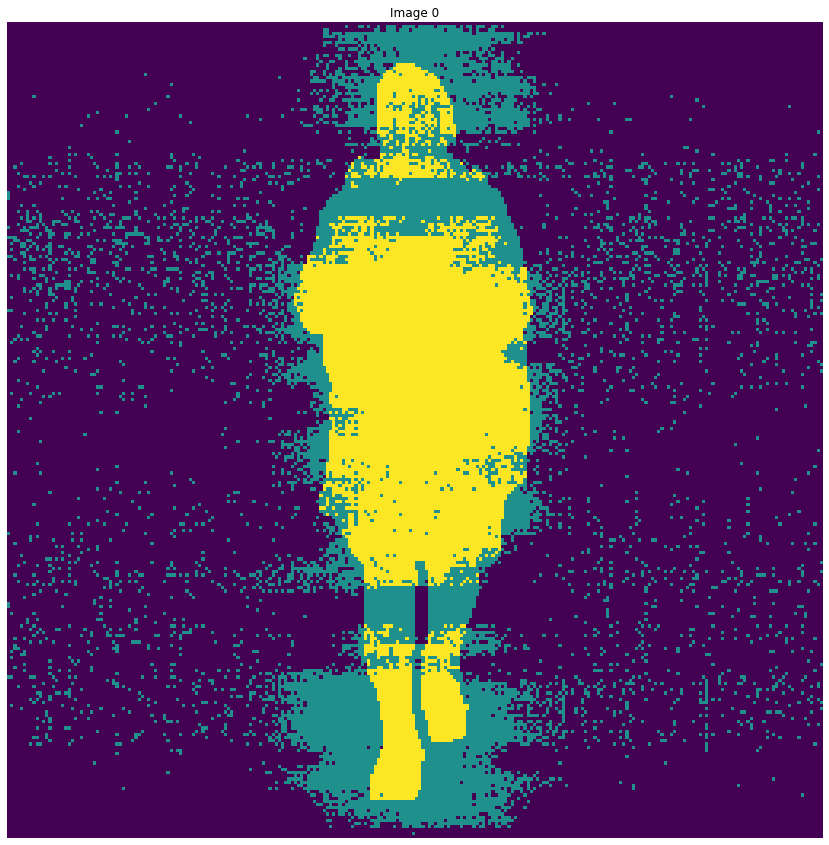

In [ ]:
for input_batch, target_batch in m_val_ds.take(1):
    for input, target in zip(input_batch, target_batch):
        input = tf.reshape(input, (1,IMAGE_SIZE,IMAGE_SIZE))
        target = tf.reshape(target, (1,IMAGE_SIZE,IMAGE_SIZE))
        synth = m_generator(input)

        print("=======ACCURACY======")
        %time print(f"{mask_accuracy(target, synth):0.4f}")
        print("=========IOU=========")
        %time print(f"{mask_iou(target, synth):0.4f}")

        iou = visual_iou(target, synth)
        display_images(iou)

## Image Recovery

In [36]:
i_train_ds, i_val_ds = get_image_ds()

Found 564 files belonging to 1 classes.
Found 564 files belonging to 1 classes.
Found 564 files belonging to 1 classes.
Found 3 files belonging to 1 classes.
Found 3 files belonging to 1 classes.
Found 3 files belonging to 1 classes.


In [49]:
i_generator = build_image_generator()
i_critic = build_image_critic()

image_gen_optimizer = tf.optimizers.RMSprop(GEN_LR)
image_crit_optimizer = tf.optimizers.RMSprop(CRITIC_LR)

image_recoverer = Image_Recovery_GAN(i_generator, i_critic)
image_recoverer.compile(image_gen_optimizer, image_crit_optimizer, generator_loss_fn, critic_loss_fn)
%time image_recoverer.fit(i_train_ds, i_val_ds, 1000)

2/1000 G_Loss: -0.0001042965 C_Loss: 0.0399225578 Time taken: 1.5402

KeyboardInterrupt: ignored

tf.Tensor([53.08049], shape=(1,), dtype=float32)


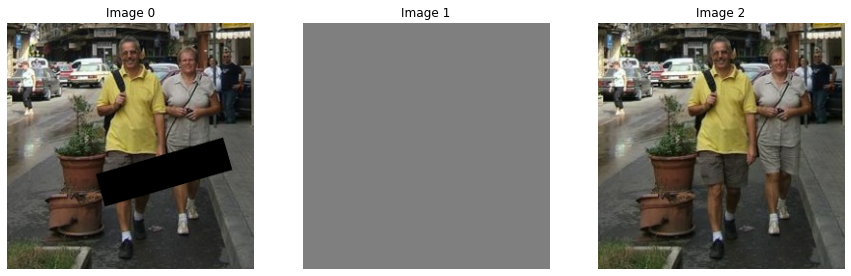

In [56]:
for input_batch, mask_batch, target_batch in i_val_ds.take(1):
    for input, mask, target in zip(input_batch, mask_batch, target_batch):
        mask = tf.expand_dims(mask, 2)
        zeros = tf.zeros((256,256,2))
        inputs = tf.concat([input, mask, zeros], axis=2)
        inputs = tf.expand_dims(inputs, axis=0)
        gen_out = image_recoverer(inputs)
        print(tf.image.psnr(input, gen_out, 255))
        display_images(input *0.5 + 0.5, gen_out*0.5+0.5, target*0.5+0.5)

# Segmentation model

In [ ]:
# THIS IS NOT MY MODEL, THIS IS IMPLEMENTED BY THE TENSORFLOW DEVELOPMENT TEAM 
# AND DESIGNED IN "Mask R-CNN" https://arxiv.org/pdf/1703.06870.pdf 
# I HAVE NOT ALTERED OR MODIFIED THIS MODEL, AND DO NOT CLAIM THIS AS MY OWN. 
# THIS MODEL IS AVAILABLE TO USE VIA THE APACHE 2.0 LICENSE HERE: 
# https://opensource.org/licenses/Apache-2.0
segmen = hub.load("https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1")

In [ ]:
def predict_mask(model, image):
    pred = model(image)
    output = {k: v.numpy() for k, v in pred.items()}
    detection_masks = tf.convert_to_tensor(output['detection_masks'][0])
    detection_boxes = tf.convert_to_tensor(output['detection_boxes'][0])
    detection_masks_reframed = ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[1], image.shape[2])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
    output['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output


In [ ]:
for input_batch, mask_batch, target_batch in i_val_ds.take(1):
    for input, mask, target in zip(input_batch, mask_batch, target_batch):
        input = tf.cast((input+1)*127.5, tf.uint8)
        pred = predict_mask(segmen, tf.expand_dims(input,0))

In [ ]:
for input_batch, mask_batch, target_batch in i_val_ds.take(1):
    for input, mask, target in zip(input_batch, mask_batch, target_batch):
        input = tf.cast((input+1)*127.5, tf.uint8)
        pred = predict_mask(segmen, tf.expand_dims(input,0))

In [ ]:
display_images(pred['detection_masks_reframed'][pred['detection_classes'][0] == 1][2], input)

In [ ]:
person_masks = pred['detection_masks_reframed'][pred['detection_classes'][0] == 1]

In [ ]:
display_images(person_masks[0] > 0)

In [ ]:
rs_mask_1 = tf.reshape(person_masks[0] > 0 , (65536))
rs_mask_2 = tf.reshape(person_masks[1] > 0 , (65536))

In [ ]:
def mask_f1(synth_mask, real_mask):
    start = time()
    tp, fp, tn, fn = 0, 0, 0,0
    synth_mask = tf.reshape(synth_mask > 0 , [-1])
    real_mask = tf.reshape(real_mask > 0 , [-1])

    for fake, real in zip(synth_mask, real_mask):
        if fake == False:
            if real == False:
                tn += 1
            else:
                fn += 1
        else:
            if real == False:
                fp += 1
            else:
                tp += 1
    print(time() - start)
    return tp / (tp + 0.5*(fp+fn))

In [ ]:
for input_batch, target_batch in m_val_ds.take(1):
    for input, target in zip(input_batch, target_batch):
        print(mask_f1(target, input))

#saving and loading test

In [ ]:
!unzip /content/220422-0901.zip -d /content/mask_gen

In [ ]:
mask_gen2 = GAN()
mask_gen2.load_model("/content/mask_gen/220422-0901")

In [ ]:
for input_batch, target_batch in m_val_ds.take(1):
    for input, target in zip(input_batch, target_batch):
        input = tf.reshape(input, (1,IMAGE_SIZE,IMAGE_SIZE))
        target = tf.reshape(target, (1,IMAGE_SIZE,IMAGE_SIZE))
        synth = mask_gen2(input)

        print("=======ACCURACY======")
        %time print(f"{mask_accuracy(target, synth):0.4f}")
        print("=========IOU=========")
        %time print(f"{mask_iou(target, synth):0.4f}")

        iou = visual_iou(target, synth)
        display_images(iou)

#Testing

In [77]:
inception = tf.keras.applications.InceptionV3()

def calculate_fid(model, predicted_images, real_images, test=False):
    pred_resized = tf.keras.preprocessing.image.smart_resize(predicted_images,(299,299))
    real_resized = tf.keras.preprocessing.image.smart_resize(real_images,(299,299))
    pred_results = model(pred_resized)
    real_results = model(real_resized)

    if test:
        print(pred_results, real_results)

    pred_mu = tf.reduce_mean(pred_results)
    real_mu = tf.reduce_mean(real_results)
    pred_sig = np.cov(pred_results, rowvar=False)
    real_sig = np.cov(real_results, rowvar=False)

    ssdif = np.sum((pred_mu-real_mu)**2)
    cov_mean = sqrtm(np.dot(pred_sig, real_sig))

    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    fid = ssdif + np.trace(pred_sig + real_sig - 2 * cov_mean)
    print(f"FID: {fid:.4f}")
    return fid


    

In [80]:
for input_batch, mask_batch, target_batch in i_train_ds.take(5):
    input = assemble_image(input_batch, mask_batch)
    gen_out = image_recoverer(input)

    fid = calculate_fid(inception, gen_out, target_batch, test=True)

tf.Tensor(
[[0.00041826 0.0003299  0.00025311 ... 0.0001245  0.00022908 0.00084129]
 [0.00041851 0.00032993 0.00025306 ... 0.00012455 0.00022917 0.00084032]
 [0.00041822 0.00032985 0.00025302 ... 0.00012452 0.00022911 0.00084063]
 [0.00041883 0.00033005 0.00025313 ... 0.00012462 0.00022931 0.00084019]], shape=(4, 1000), dtype=float32) tf.Tensor(
[[6.98071308e-05 2.38217472e-05 2.67717405e-04 ... 5.39991743e-05
  4.54015390e-05 3.11225594e-04]
 [4.41187003e-04 2.01373492e-04 2.23026567e-04 ... 1.16665971e-04
  1.45723738e-04 2.37451633e-04]
 [2.03691779e-05 8.83123812e-06 1.59616866e-05 ... 4.14341703e-05
  2.37520417e-05 7.88394536e-05]
 [2.28724079e-04 1.13662514e-04 1.73557128e-04 ... 2.52218219e-04
  2.80900160e-04 3.95998039e-04]], shape=(4, 1000), dtype=float32)
tf.Tensor(
[[0.00041789 0.00032989 0.00025298 ... 0.0001244  0.00022907 0.00084149]
 [0.00041832 0.00033    0.0002532  ... 0.00012455 0.0002292  0.00084111]
 [0.00041863 0.00033    0.00025313 ... 0.00012461 0.00022919 0.00

0.3617128188129419
